In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [ ]:
spark=SparkSession.builder.getOrCreate()

In [ ]:
msnpc=spark.read.csv("MsNPC.csv",header=True, inferSchema=True)
msplayer=spark.read.csv("MsPlayer.csv",header=True, inferSchema=True)
msweapon=spark.read.csv("MsWeapon.csv",header=True, inferSchema=True)
msweapontype=spark.read.csv("MsWeaponType.csv",header=True, inferSchema=True)
transacdet=spark.read.csv("TransactionDetail.csv",header=True, inferSchema=True)
transacheader=spark.read.csv("TransactionHeader.csv",header=True, inferSchema=True)

msnpc.createOrReplaceTempView("MsNPC")
msplayer.createOrReplaceTempView("MsPlayer")
msweapon.createOrReplaceTempView("MsWeapon")
msweapontype.createOrReplaceTempView("MsWeaponType")
transacdet.createOrReplaceTempView("TransactionDetail")
transacheader.createOrReplaceTempView("TransactionHeader")

In [ ]:
# 2a
res1=spark.sql("SELECT WeaponTypeName, SUM(WeaponPrice*Quantity) AS WTtotal FROM MsWeaponType MWT JOIN MsWeapon MW ON MWT.WeaponTypeId=MW.WeaponTypeID JOIN TransactionDetail TD ON TD.WeaponId=MW.WeaponId JOIN TransactionHeader TH ON TH.TransactionId=TD.TransactionId WHERE YEAR(TransactionDate)=2019 GROUP BY WeaponTypeName ORDER BY WTtotal ASC")
res1=res1.toPandas()

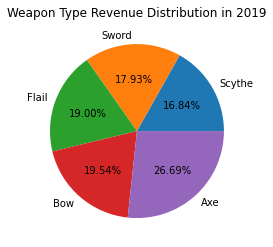

In [ ]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1["WTtotal"],labels=res1["WeaponTypeName"],autopct="%.2f%%")
plt.show()

In [ ]:
# 2b
res2=spark.sql("SELECT COUNT(DISTINCT PlayerId) AS PlayerCount, Month(TransactionDate) AS Month FROM TransactionHeader TH JOIN TransactionDetail TD ON TD.TransactionId=TH.TransactionId JOIN MsWeapon MW ON MW.WeaponId=TD.WeaponId JOIN MsWeaponType MWT ON MWT.WeaponTypeId=MW.WeaponTypeId WHERE YEAR(TransactionDate)=2019 AND WeaponTypeName='Axe'GROUP BY Month(TransactionDate) ORDER BY Month")
res2=res2.toPandas()

Text(0, 0.5, 'Player Count')

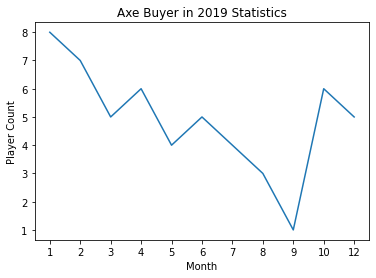

In [ ]:
plt.title("Axe Buyer in 2019 Statistics")
plt.plot(res2['PlayerCount'])
plt.xticks(range(len(res2['Month'])),res2['Month'])
plt.xlabel('Month')
plt.ylabel('Player Count')

In [ ]:
# 2c
res3=spark.sql("SELECT X.MonthlySpending, COUNT(X.MonthlySpending) AS Frequency FROM(SELECT PlayerName, CASE WHEN SUM(TD.Quantity*MW.WeaponPrice)>2000000 THEN 'Extinction' WHEN SUM(TD.Quantity*MW.WeaponPrice)<=1999999 AND SUM(TD.Quantity*MW.WeaponPrice)>=1500000 THEN 'Nightfall' WHEN SUM(TD.Quantity*MW.WeaponPrice)>= 1000000 AND SUM(TD.Quantity*MW.WeaponPrice)< 1499999 THEN 'Storm Breaker' ELSE 'NO' END AS MonthlySpending FROM MsPlayer MP JOIN TransactionHeader TH ON MP.PlayerId=TH.PlayerId JOIN TransactionDetail TD on TD.TransactionId=TH.TransactionId JOIN MsWeapon MW ON MW.WeaponId=TD.WeaponId WHERE PlayerGender='Female' AND YEAR(TH.TransactionDate)=2019 GROUP BY MONTH(TransactionDate), PlayerName)AS X  WHERE X.MonthlySpending <>'NO' GROUP BY X.MonthlySpending ORDER BY CASE WHEN MonthlySpending='Storm Breaker' THEN 1 WHEN MonthlySpending='Extinction' THEN 2 WHEN MonthlySpending='Nightfall' THEN 3 END")
res3=res3.toPandas()

In [ ]:
res3

<BarContainer object of 3 artists>

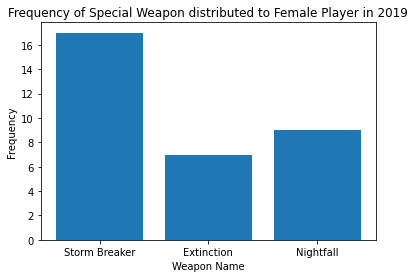

In [ ]:
plt.title("Frequency of Special Weapon distributed to Female Player in 2019") 
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.bar(res3['MonthlySpending'],res3['Frequency'])

In [ ]:
# 2d
res4=spark.sql("SELECT X.Month, COUNT(DISTINCT PlayerId) AS PlayerCount FROM (SELECT PlayerId, MONTH(TransactionDate) AS Month FROM TransactionHeader TH JOIN TransactionDetail TD ON TD.TransactionId=TH.TransactionId JOIN MsWeapon MW ON MW.WeaponId=TD.WeaponId WHERE YEAR(TransactionDate)=2019  GROUP BY PlayerId,MONTH(TransactionDate) HAVING COUNT(DISTINCT WeaponTypeId)>=3) AS X GROUP BY X.Month ORDER BY X.Month")
res4=res4.toPandas()


Text(0, 0.5, 'Player Count')

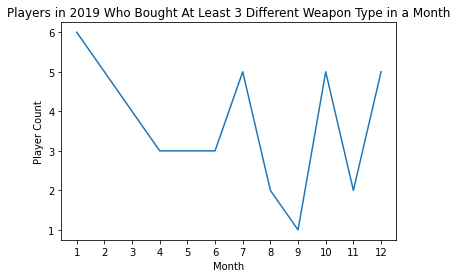

In [ ]:
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.plot(res4['PlayerCount'])
plt.xticks(range(len(res4['Month'])),res4['Month'])
plt.xlabel('Month')
plt.ylabel('Player Count')

In [ ]:
# 2e
res5=spark.sql("SELECT X.Popularity, COUNT(X.Popularity) AS Frequency FROM (SELECT MPc.NPCId, CASE WHEN SUM(Mw.WeaponPrice*TD.Quantity)>=15000000 THEN 'Very Popular'WHEN SUM(Mw.WeaponPrice*TD.Quantity)>=7500000 AND SUM(WeaponPrice*Quantity) <15000000 THEN 'Popular' WHEN SUM(MW.WeaponPrice*TD.Quantity)>=2500000 AND SUM(MW.WeaponPrice*TD.Quantity)<7500000 THEN 'Quite Popular' ELSE 'Not Popular' END AS Popularity FROM MsNPC MPc JOIN TransactionHeader TH ON TH.NPCId=MPc.NPCId JOIN TransactionDetail TD ON TD.TransactionId=TH.TransactionId JOIN MsWeapon MW ON MW.WeaponId=TD.WeaponId GROUP BY MPc.NPCId HAVING COUNT(DISTINCT PlayerId)>=5)AS X GROUP BY X.Popularity ORDER BY CASE WHEN Popularity='Quite Popular' THEN 1 WHEN Popularity='Popular' THEN 2 WHEN Popularity='Very Popular' THEN 3 END")
res5=res5.toPandas()

In [ ]:
res5

,Popularity,Frequency
0,Quite Popular,2
1,Popular,8
2,Very Popular,2


<BarContainer object of 3 artists>

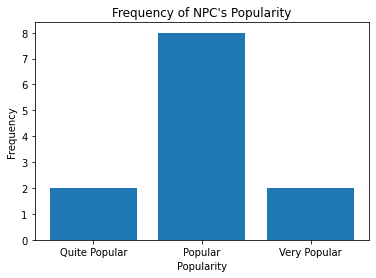

In [ ]:
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.bar(res5['Popularity'],res5['Frequency'])